In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

#### Functions

In [6]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # any units with no firing will have a row of nans
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

# Multi-subject P1-N1 analysis: quantify on single trials

In [7]:
sub_dirs = {}

## Mice that have white fullscreen flashes ##
sub_dirs['fullscreen'] = {
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\audio_vis1_2020-07-08_12-37-58\recording1',
#     '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\audio_vis1_2020-07-15_13-28-29\recording1',
    '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\audio_vis1_2020-08-26_11-47-55\experiment1\recording1',
#     '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\audio_vis1_2020-09-02_13-25-18\experiment1\recording1',
    '543396': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
#     '546655': r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
#     '551400': r'F:\EEG_exp\mouse551400\estim_vis_2021-01-22_11-07-12\experiment1\recording1',
}

## Mice that have white circle flashes ##
sub_dirs['circle'] = {
    '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
#     '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
#     '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
#     '569073': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
}

Load meta data to get bad chs

In [8]:
vismetadata = pd.read_excel(
    r'C:\Users\lesliec\OneDrive - Allen Institute\EEG_exp info.xlsx',
    sheet_name='Visual Experiments',
    dtype=str
)
vismetadata = vismetadata.astype({'Bad chs': str})
# vismetadata.head()

### Choose visual stim type

In [9]:
stim_type = 'circle'

Load experiments

In [10]:
sub_exp = {}
for mousei, recdiri in sub_dirs[stim_type].items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [11]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'LFP_EEG_grant')
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

Load data

In [12]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim
param = 'white'

## EEG params ##
apply_hpass = True
apply_car = True

In [13]:
EEG_traces = {}
sub_good_chs = {}
sub_trial_count = {}
for mousei, expi in sub_exp.items():
    print(mousei)
    start = time.time()
    ## Grab exp metadata from Zap_Zip-log_exp ##
    expi_meta = vismetadata[(
        (vismetadata['Mouse'].str.contains(expi.mouse))
    )].squeeze()
    
    ## Get bad_ch_list from metadata ##
    badchstr = expi_meta['Bad chs'].replace(' ','')
    bad_ch_list = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_ch_list.append(int(char))
            
    ## Get sweep list from metadata ##
    awsweepstr = expi_meta['Awake sweeps'].replace(' ','')
    awake_sweeps = []
    for char in awsweepstr.split(','):
        if char.isdecimal():
            awake_sweeps.append(int(char))
    answeepstr = expi_meta['Iso sweeps'].replace(' ','')
    anest_sweeps = []
    for char in answeepstr.split(','):
        if char.isdecimal():
            anest_sweeps.append(int(char))
    state_sweeps = {'awake': awake_sweeps, 'anesthetized': anest_sweeps}
    
    ## Load stim log ##
    stim_log = pd.read_csv(expi.stimulus_log_file)
    
    ## Load running signal ##
    run_signal, run_timestamps = expi.load_running()
    
    ### Load EEG data ###
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in bad_ch_list])
            
    ## Apply high-pass filter ##
    if apply_hpass:
        hpb, hpa = signal.butter(3, 0.1/(expi.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    
    ## Get evoked traces ##
    EEG_traces[mousei] = {}
    trial_count = []
    for statei, sweeps in state_sweeps.items():
        state_events = []
        for sweepi in sweeps:
            events = get_stim_events(stim_log, stim_type, param, sweepi)
            if len(events) == 0:
                continue
            state_events.append(events)
        state_events = np.concatenate(state_events)
        ## Get evoked EEG traces ##
        event_traces, event_ts = get_evoked_traces(
            datai,
            tsi,
            state_events,
            before_event,
            after_event,
            expi.ephys_params['EEG']['sample_rate']
        )
        # apply common avg
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
        # apply lowpass filter
        filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
        event_traces = signal.filtfilt(filtb, filta, event_traces, axis=0)
        
        if statei == 'awake':
            ## Get mean speed ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_trials = np.nonzero(mean_speed < 0.5)[0]
            run_trials = np.nonzero(mean_speed >= 0.5)[0]
            
            EEG_traces[mousei]['resting'] = [event_ts, event_traces[:, :, rest_trials]]
            EEG_traces[mousei]['running'] = [event_ts, event_traces[:, :, run_trials]]
            trial_count.append(len(rest_trials))
            trial_count.append(len(run_trials))
        else:
            EEG_traces[mousei][statei] = [event_ts, event_traces]
            trial_count.append(len(state_events))
                
    sub_good_chs[mousei] = good_chs
    sub_trial_count[mousei] = trial_count
            
    del datai
    del tsi
    del stim_log
    del run_signal
    del run_timestamps

    end = time.time()
    print('Time to analyze: {:.2f} min'.format((end - start) / 60))

551397
Time to analyze: 1.94 min
569062
Time to analyze: 0.75 min
569069
Time to analyze: 1.73 min
569072
Time to analyze: 0.53 min


Plot

### Quantification of response

Metrics tested: min/time of min, max/time of max, std, area under curve.
<br>Time windows tested: 100, 250, 500 ms.

In [32]:
test_windows = [0.1, 0.25, 0.5] # measuring signal between 0 and x s post-stim onset

mouse_list = []
state_list = []
window_list = []
min_list = []
mintime_list = []
max_list = []
maxtime_list = []
std_list = []
auc_list = []
min_list_sem = []
mintime_list_sem = []
max_list_sem = []
maxtime_list_sem = []
std_list_sem = []
auc_list_sem = []
for mouse in EEG_traces.keys():
    for window in test_windows:
        for statei, datai in EEG_traces[mouse].items():
            mouse_list.append(mouse)
            state_list.append(statei)
            window_list.append(window)
            
            timex = datai[0]
            trace = datai[1][:, 4, :] # only analyzing ch 4 over left V1, all trials
            qinds = np.nonzero((timex >= 0) & (timex <= window))[0]
            ## min and min time ##
            min_list.append(np.mean(np.min(trace[qinds,:], axis=0)))
            min_list_sem.append(stats.sem(np.min(trace[qinds,:], axis=0)))
            mintime_list.append(np.mean(timex[qinds][np.argmin(trace[qinds,:], axis=0)]))
            mintime_list_sem.append(stats.sem(timex[qinds][np.argmin(trace[qinds,:], axis=0)]))
            ## max and max time ##
            max_list.append(np.mean(np.max(trace[qinds,:], axis=0)))
            max_list_sem.append(stats.sem(np.max(trace[qinds,:], axis=0)))
            maxtime_list.append(np.mean(timex[qinds][np.argmax(trace[qinds,:], axis=0)]))
            maxtime_list_sem.append(stats.sem(timex[qinds][np.argmax(trace[qinds,:], axis=0)]))
            ## std ##
            std_list.append(np.mean(np.std(trace[qinds,:], axis=0)))
            std_list_sem.append(stats.sem(np.std(trace[qinds,:], axis=0)))
            ## area under abs curve ##
            auc_list.append(np.mean(integrate.simps(np.abs(trace[qinds,:]), timex[qinds], axis=0, even='last')))
            auc_list_sem.append(stats.sem(integrate.simps(np.abs(trace[qinds,:]), timex[qinds], axis=0, even='last')))
metricsdf = pd.DataFrame({
    'mouse': mouse_list,
    'state': state_list,
    'window': window_list,
    'min_value': min_list,
    'min_time': mintime_list,
    'max_value': max_list,
    'max_time': maxtime_list,
    'std': std_list,
    'auc': auc_list,
    'min_value_sem': min_list_sem,
    'min_time_sem': mintime_list_sem,
    'max_value_sem': max_list_sem,
    'max_time_sem': maxtime_list_sem,
    'std_sem': std_list_sem,
    'auc_sem': auc_list_sem,
})
metricsdf.head()

,mouse,state,window,min_value,min_time,max_value,max_time,std,auc,min_value_sem,min_time_sem,max_value_sem,max_time_sem,std_sem,auc_sem
0,551397,resting,0.10,-35.639154,0.063286,34.669802,0.042663,18.204123,1.697445,1.291459,0.003353,1.506939,0.002711,0.570010,0.060377
1,551397,running,0.10,-41.086280,0.057600,31.428276,0.035200,17.533052,1.509236,5.402131,0.013947,4.158507,0.008030,1.480167,0.136856
2,551397,anesthetized,0.10,-29.992033,0.051543,32.749108,0.058257,16.064408,1.496050,1.605010,0.002905,1.254807,0.003011,0.548635,0.050544
3,551397,resting,0.25,-48.102659,0.138641,43.091909,0.113820,20.599888,4.330735,1.190156,0.006622,1.361175,0.007285,0.533442,0.115060
4,551397,running,0.25,-48.964617,0.082400,42.558703,0.157650,19.188239,3.916040,4.834335,0.017873,3.275437,0.030924,1.208754,0.249348


<IPython.core.display.Javascript object>


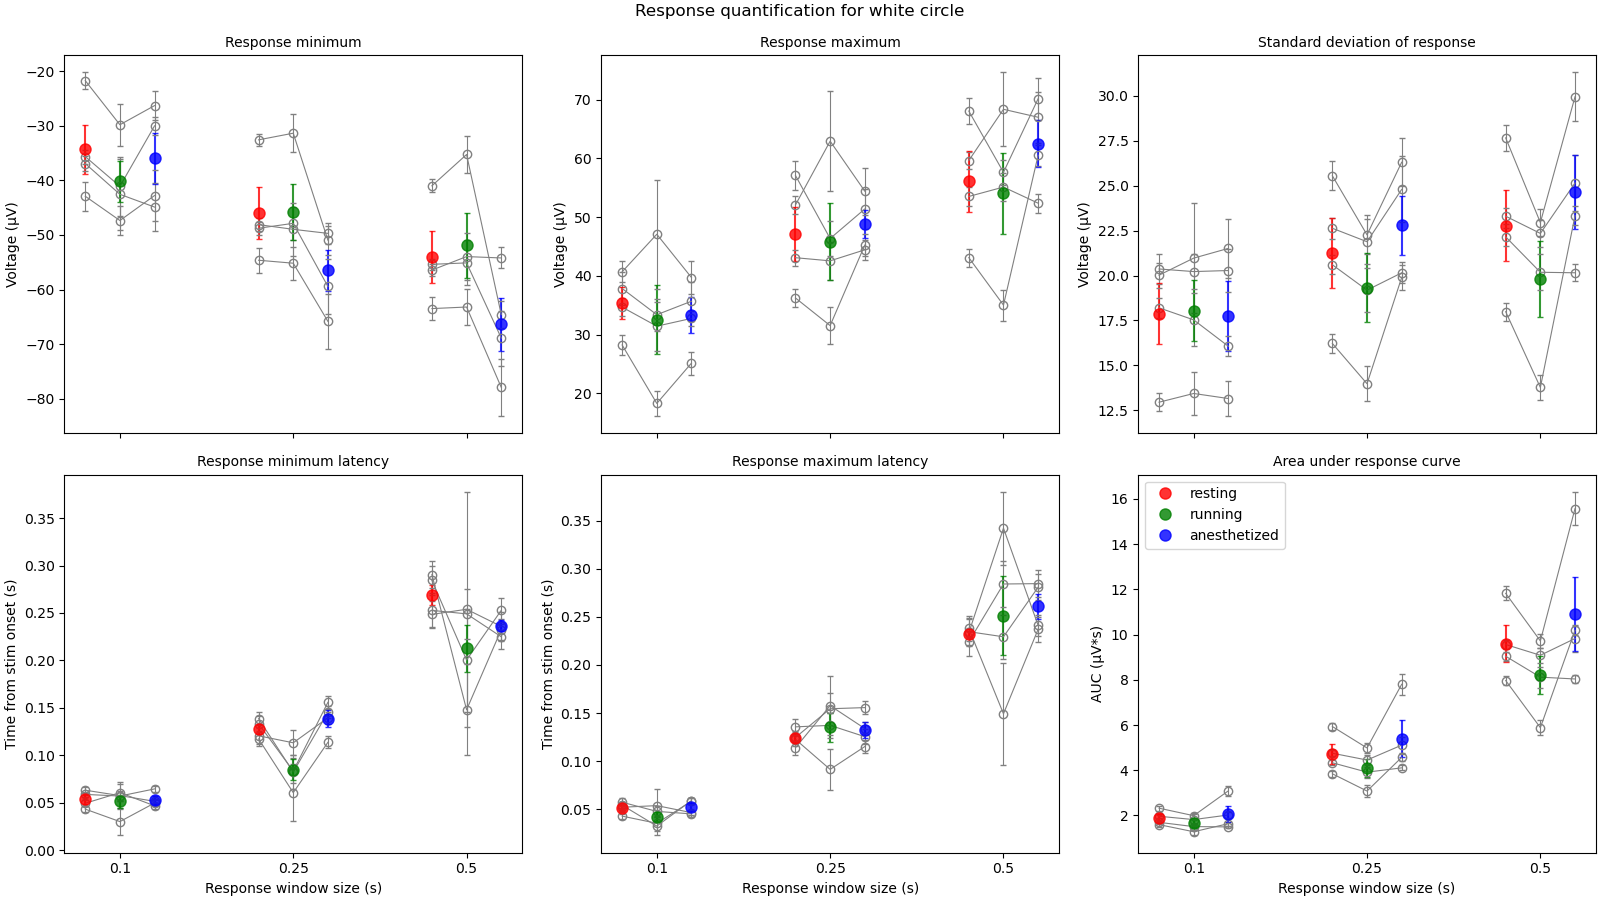

In [37]:
metrics_labels = {
    'min_value': 'Response minimum',
    'max_value': 'Response maximum',
    'std': 'Standard deviation of response',
    'min_time': 'Response minimum latency',
    'max_time': 'Response maximum latency',
    'auc': 'Area under response curve'
}
metrics_ylabels = {
    'min_value': 'Voltage (\u03bcV)',
    'max_value': 'Voltage (\u03bcV)',
    'std': 'Voltage (\u03bcV)',
    'min_time': 'Time from stim onset (s)',
    'max_time': 'Time from stim onset (s)',
    'auc': 'AUC (\u03BCV*s)'
}
stcolors = {'resting': 'r', 'running': 'g', 'anesthetized': 'b'}
xpos = [-0.2, 0, 0.2]
colpos = np.arange(len(test_windows))
fig, axs = plt.subplots(2, 3, figsize=(16,9), constrained_layout=True, sharex=True)

for ax, (metric, title) in zip(axs.ravel(), metrics_labels.items()):
    legend_entries = []
    for col, window in zip(colpos, test_windows):
        metvals = []
        metsem = []
        for statei in list(stcolors.keys()):
            metvals.append(metricsdf[metric][(metricsdf['window'] == window) & (metricsdf['state'] == statei)].values)
            metsem.append(metricsdf[metric+'_sem'][(metricsdf['window'] == window) & (metricsdf['state'] == statei)].values)
        state_vals = np.array(metvals)
        val_sem = np.array(metsem)
        for j in range(state_vals.shape[1]):
            ax.errorbar(col+xpos, state_vals[:,j], yerr=val_sem[:,j], color='gray', linewidth=0.8, marker='o', fillstyle='none')
        for ii, statei in enumerate(list(stcolors.keys())):
            ax.errorbar(
                col+xpos[ii], np.mean(state_vals[ii, :]), yerr=stats.sem(state_vals[ii, :]),
                color=stcolors[statei], linewidth=1.5, marker='o', markersize=8, alpha=0.8
            )
            if col == 0:
                legend_entries.append(
                    Line2D([0], [0], color='none', marker='o',
                           markerfacecolor=stcolors[statei],
                           markeredgecolor=stcolors[statei],
                           markersize=8, alpha=0.8, label=statei)
                )
    ax.set_xticks(colpos)
    ax.set_xticklabels(test_windows)
    
    ax.set_ylabel(metrics_ylabels[metric])
    ax.set_title(title)
ax.legend(handles=legend_entries)
axs[1,0].set_xlabel('Response window size (s)')
axs[1,1].set_xlabel('Response window size (s)')
axs[1,2].set_xlabel('Response window size (s)')
plt.suptitle('Response quantification for {} {}'.format(param, stim_type))

## Save ##
figname = '{}_response_metrics_indtrials.png'.format(stim_type)
fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

# Multi-subject P1-N1 analysis: average first -> quantify

In [7]:
sub_dirs = {}

## Mice that have white fullscreen flashes ##
sub_dirs['fullscreen'] = {
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\audio_vis1_2020-07-08_12-37-58\recording1',
#     '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\audio_vis1_2020-07-15_13-28-29\recording1',
    '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\audio_vis1_2020-08-26_11-47-55\experiment1\recording1',
#     '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\audio_vis1_2020-09-02_13-25-18\experiment1\recording1',
    '543396': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
#     '546655': r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
#     '551400': r'F:\EEG_exp\mouse551400\estim_vis_2021-01-22_11-07-12\experiment1\recording1',
}

## Mice that have white circle flashes ##
sub_dirs['circle'] = {
    '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
#     '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
#     '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
#     '569073': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
}

Load meta data to get bad chs

In [8]:
vismetadata = pd.read_excel(
    r'C:\Users\lesliec\OneDrive - Allen Institute\EEG_exp info.xlsx',
    sheet_name='Visual Experiments',
    dtype=str
)
vismetadata = vismetadata.astype({'Bad chs': str})
# vismetadata.head()

### Choose visual stim type

In [9]:
stim_type = 'circle'

Load experiments

In [10]:
sub_exp = {}
for mousei, recdiri in sub_dirs[stim_type].items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [11]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'LFP_EEG_grant')
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

Load data

In [12]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim
param = 'white'

## EEG params ##
apply_hpass = True
apply_car = True

In [13]:
EEG_traces = {}
sub_good_chs = {}
sub_trial_count = {}
for mousei, expi in sub_exp.items():
    print(mousei)
    start = time.time()
    ## Grab exp metadata from Zap_Zip-log_exp ##
    expi_meta = vismetadata[(
        (vismetadata['Mouse'].str.contains(expi.mouse))
    )].squeeze()
    
    ## Get bad_ch_list from metadata ##
    badchstr = expi_meta['Bad chs'].replace(' ','')
    bad_ch_list = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_ch_list.append(int(char))
            
    ## Get sweep list from metadata ##
    awsweepstr = expi_meta['Awake sweeps'].replace(' ','')
    awake_sweeps = []
    for char in awsweepstr.split(','):
        if char.isdecimal():
            awake_sweeps.append(int(char))
    answeepstr = expi_meta['Iso sweeps'].replace(' ','')
    anest_sweeps = []
    for char in answeepstr.split(','):
        if char.isdecimal():
            anest_sweeps.append(int(char))
    state_sweeps = {'awake': awake_sweeps, 'anesthetized': anest_sweeps}
    
    ## Load stim log ##
    stim_log = pd.read_csv(expi.stimulus_log_file)
    
    ## Load running signal ##
    run_signal, run_timestamps = expi.load_running()
    
    ### Load EEG data ###
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in bad_ch_list])
            
    ## Apply high-pass filter ##
    if apply_hpass:
        hpb, hpa = signal.butter(3, 0.1/(expi.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    
    ## Get evoked traces ##
    EEG_traces[mousei] = {}
    trial_count = []
    for statei, sweeps in state_sweeps.items():
        state_events = []
        for sweepi in sweeps:
            events = get_stim_events(stim_log, stim_type, param, sweepi)
            if len(events) == 0:
                continue
            state_events.append(events)
        state_events = np.concatenate(state_events)
        ## Get evoked EEG traces ##
        event_traces, event_ts = get_evoked_traces(
            datai,
            tsi,
            state_events,
            before_event,
            after_event,
            expi.ephys_params['EEG']['sample_rate']
        )
        # apply common avg
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
        # apply lowpass filter
        filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
        event_traces = signal.filtfilt(filtb, filta, event_traces, axis=0)
        
        if statei == 'awake':
            ## Get mean speed ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_trials = np.nonzero(mean_speed < 0.5)[0]
            run_trials = np.nonzero(mean_speed >= 0.5)[0]
            
            EEG_traces[mousei]['resting'] = [event_ts, np.mean(event_traces[:, :, rest_trials], axis=2)]
            EEG_traces[mousei]['running'] = [event_ts, np.mean(event_traces[:, :, run_trials], axis=2)]
            trial_count.append(len(rest_trials))
            trial_count.append(len(run_trials))
        else:
            EEG_traces[mousei][statei] = [event_ts, np.mean(event_traces, axis=2)]
            trial_count.append(len(state_events))
                
    sub_good_chs[mousei] = good_chs
    sub_trial_count[mousei] = trial_count
            
    del datai
    del tsi
    del stim_log
    del run_signal
    del run_timestamps

    end = time.time()
    print('Time to analyze: {:.2f} min'.format((end - start) / 60))

551397
Time to analyze: 2.00 min
569062
Time to analyze: 0.83 min
569069
Time to analyze: 1.70 min
569072
Time to analyze: 0.54 min


Plot

### Quantification of response

Metrics tested: min/time of min, max/time of max, std, area under curve.
<br>Time windows tested: 100, 250, 500 ms.

In [14]:
test_windows = [0.1, 0.25, 0.5] # measuring signal between 0 and x s post-stim onset

mouse_list = []
state_list = []
window_list = []
min_list = []
mintime_list = []
max_list = []
maxtime_list = []
std_list = []
auc_list = []
for mouse in EEG_traces.keys():
    for window in test_windows:
        for statei, datai in EEG_traces[mouse].items():
            mouse_list.append(mouse)
            state_list.append(statei)
            window_list.append(window)
            
            timex = datai[0]
            trace = datai[1][:, 4] # only analyzing ch 4 over left V1
            qinds = np.nonzero((timex >= 0) & (timex <= window))[0]
            ## min and min time ##
            min_list.append(np.min(trace[qinds]))
            mintime_list.append(timex[qinds][np.argmin(trace[qinds])])
            ## max and max time ##
            max_list.append(np.max(trace[qinds]))
            maxtime_list.append(timex[qinds][np.argmax(trace[qinds])])
            ## std ##
            std_list.append(np.std(trace[qinds]))
            ## area under abs curve ##
            auc_list.append(integrate.simps(np.abs(trace[qinds]), timex[qinds], axis=0, even='last'))
metricsdf = pd.DataFrame({
    'mouse': mouse_list,
    'state': state_list,
    'window': window_list,
    'min_value': min_list,
    'min_time': mintime_list,
    'max_value': max_list,
    'max_time': maxtime_list,
    'std': std_list,
    'auc': auc_list,
})
metricsdf.head()

,mouse,state,window,min_value,min_time,max_value,max_time,std,auc
0,551397,resting,0.10,-13.900719,0.0968,6.264527,0.0092,5.295932,0.434100
1,551397,running,0.10,-14.596564,0.0880,10.882011,0.0396,6.820483,0.559783
2,551397,anesthetized,0.10,-1.398821,0.0236,7.137698,0.0932,2.421591,0.220621
3,551397,resting,0.25,-13.900719,0.0968,6.264527,0.0092,5.585295,1.225333
4,551397,running,0.25,-14.596564,0.0880,15.268386,0.2316,6.724347,1.392799


<IPython.core.display.Javascript object>


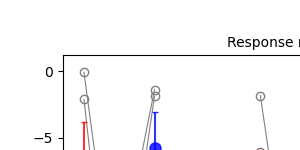

In [15]:
metrics_labels = {
    'min_value': 'Response minimum',
    'max_value': 'Response maximum',
    'std': 'Standard deviation of response',
    'min_time': 'Response minimum latency',
    'max_time': 'Response maximum latency',
    'auc': 'Area under response curve'
}
metrics_ylabels = {
    'min_value': 'Voltage (\u03bcV)',
    'max_value': 'Voltage (\u03bcV)',
    'std': 'Voltage (\u03bcV)',
    'min_time': 'Time from stim onset (s)',
    'max_time': 'Time from stim onset (s)',
    'auc': 'AUC (\u03BCV*s)'
}
stcolors = {'resting': 'r', 'running': 'g', 'anesthetized': 'b'}
xpos = [-0.2, 0, 0.2]
colpos = np.arange(len(test_windows))
fig, axs = plt.subplots(2, 3, figsize=(16,9), constrained_layout=True, sharex=True)

for ax, (metric, title) in zip(axs.ravel(), metrics_labels.items()):
    legend_entries = []
    for col, window in zip(colpos, test_windows):
        metvals = []
        for statei in list(stcolors.keys()):
            metvals.append(metricsdf[metric][(metricsdf['window'] == window) & (metricsdf['state'] == statei)].values)
        state_vals = np.array(metvals)
        ax.plot(col+xpos, state_vals, color='gray', linewidth=0.8, marker='o', fillstyle='none')
        for ii, statei in enumerate(list(stcolors.keys())):
            ax.errorbar(
                col+xpos[ii], np.mean(state_vals[ii, :]), yerr=stats.sem(state_vals[ii, :]),
                color=stcolors[statei], linewidth=1.5, marker='o', markersize=8, alpha=0.8
            )
            if col == 0:
                legend_entries.append(
                    Line2D([0], [0], color='none', marker='o',
                           markerfacecolor=stcolors[statei],
                           markeredgecolor=stcolors[statei],
                           markersize=8, alpha=0.8, label=statei)
                )
    ax.set_xticks(colpos)
    ax.set_xticklabels(test_windows)
    
    ax.set_ylabel(metrics_ylabels[metric])
    ax.set_title(title)
ax.legend(handles=legend_entries)
axs[1,0].set_xlabel('Response window size (s)')
axs[1,1].set_xlabel('Response window size (s)')
axs[1,2].set_xlabel('Response window size (s)')
plt.suptitle('Response quantification for {} {}'.format(param, stim_type))

## Save ##
figname = '{}_response_metrics.png'.format(stim_type)
fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

# Combined EEG/LFP/unit zscore plot

### Load experiment instance and data

Load stimulus log and speed

Load probe info

#### Load data and collect traces

Load EEG data and good chs

Memmap LFP data

Set parameters

Awake sweep to get resting/running activity

Anesthetized sweep

### Plotting